# TODO
- Save train, val, test after combining datasets

# Exploritory Data Analysis

## Setup

In [210]:
import gc
import pathlib 

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import preprocessing

## Reading data

### 1st source (https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022)

In [211]:
source_1_dir: pathlib.Path = pathlib.Path('../datasets/raw/source_1/')

parquet_files: list[pathlib.Path] = list(source_1_dir.glob("Combined_Flights_[0-9]*.parquet"))

source_1_df: pd.DataFrame = pd.concat((pd.read_parquet(parquet_file) for parquet_file in parquet_files), ignore_index=True)

In [212]:
# For debugging purposes
source_1_df = source_1_df.sample(100000, random_state=420)

Reading file which contains feature description

In [213]:
source_1_description_df: pd.DataFrame = pd.read_html('../datasets/raw/source_1/readme.html', skiprows=5)[0]

source_1_description_df.columns = ['Name', 'Description']
source_1_description_df = source_1_description_df.set_index('Name', drop=True)
source_1_description_df

,Description
Name,
Year,Year
Quarter,Quarter (1-4)
Month,Month
DayofMonth,Day of Month
DayOfWeek,Day of Week
...,...
Div5TotalGTime,Total Ground Time Away from Gate at Diverted A...
Div5LongestGTime,Longest Ground Time Away from Gate at Diverted...
Div5WheelsOff,Wheels Off Time (local time: hhmm) at Diverted...


City name is in the format "city,state", remove the state part.

In [214]:
source_1_df['DestCityName'] = source_1_df['DestCityName'].apply(lambda x: x.split(',')[0])
source_1_df['OriginCityName'] = source_1_df['OriginCityName'].apply(lambda x: x.split(',')[0])

### 2nd source ()

In [215]:
source_2_dir: pathlib.Path = pathlib.Path('../datasets/raw/source_2/')

csv_files: list[pathlib.Path] = list(source_2_dir.glob("[0-9]*.csv"))

source_2_df: pd.DataFrame = pd.concat((pd.read_csv(csv_file, encoding='latin-1') for csv_file in csv_files), ignore_index=True)

/var/folders/c9/24l9wbvn7_l_zt25742x5qf40000gn/T/ipykernel_33963/3230565564.py:5: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  source_2_df: pd.DataFrame = pd.concat((pd.read_csv(csv_file, encoding='latin-1') for csv_file in csv_files), ignore_index=True)


In [216]:
# For debugging purposes
source_2_df = source_2_df.sample(100000, random_state=420)

In [217]:
source_2_airports_df: pd.DataFrame = pd.read_csv(source_2_dir / 'airports.csv', encoding='latin-1')
source_2_df = source_2_df.merge(source_2_airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('', '_origin'))
source_2_df = source_2_df.rename({
    'iata': 'OriginIata', 
    'airport': 'OriginAirport', 
    'city': 'OriginCityName', 
    'state': 'OriginState', 
    'country': 'OriginCountry', 
    'lat': 'OriginLat', 
    'long': 'OriginLong'}, axis=1)
source_2_df = source_2_df.merge(source_2_airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('', '_dest'))
source_2_df = source_2_df.rename({
    'iata': 'DestIata',
    'airport': 'DestAirport',
    'city': 'DestCityName',
    'state': 'DestState',
    'country': 'DestCountry',
    'lat': 'DestLat',
    'long': 'DestLong'}, axis=1)

In [218]:
source_2_carriers_df: pd.DataFrame = pd.read_csv(source_2_dir / 'carriers.csv', encoding='latin-1')
source_2_carriers_df.set_index('Code', inplace=True)

source_2_df['Airline'] = source_2_df['UniqueCarrier'].apply(lambda x: source_2_carriers_df.loc[x, 'Description'])

Reading feature descriptions

In [219]:
source_2_description_df: pd.DataFrame = pd.read_csv(source_2_dir / "variable-descriptions.csv", skiprows=2, index_col=0, usecols=['Name', 'Description'])
source_2_description_df

,Description
Name,
Year,1987-2008
Month,12-Jan
DayofMonth,31-Jan
DayOfWeek,1 (Monday) - 7 (Sunday)
DepTime,"actual departure time (local, hhmm)"
CRSDepTime,"scheduled departure time (local, hhmm)"
ArrTime,"actual arrival time (local, hhmm)"
CRSArrTime,"scheduled arrival time (local, hhmm)"
UniqueCarrier,unique carrier code


## Inspecting features from the different sources

In [220]:
missing_features: list[str] = []

for feature in source_1_df.columns:
    if feature not in source_2_df.columns:
        missing_features.append(feature)

# print(missing_features)
missing_features

# missing_features = []
# for feature in source_2_df.columns:
#     if feature not in source_1_df.columns:
#         missing_features.append(feature)

# missing_features
# print(missing_features)

['FlightDate',
 'DepDelayMinutes',
 'ArrDelayMinutes',
 'Quarter',
 'Marketing_Airline_Network',
 'Operated_or_Branded_Code_Share_Partners',
 'DOT_ID_Marketing_Airline',
 'IATA_Code_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'Operating_Airline',
 'DOT_ID_Operating_Airline',
 'IATA_Code_Operating_Airline',
 'Tail_Number',
 'Flight_Number_Operating_Airline',
 'OriginAirportID',
 'OriginAirportSeqID',
 'OriginCityMarketID',
 'OriginStateFips',
 'OriginStateName',
 'OriginWac',
 'DestAirportID',
 'DestAirportSeqID',
 'DestCityMarketID',
 'DestStateFips',
 'DestStateName',
 'DestWac',
 'DepDel15',
 'DepartureDelayGroups',
 'DepTimeBlk',
 'WheelsOff',
 'WheelsOn',
 'ArrDel15',
 'ArrivalDelayGroups',
 'ArrTimeBlk',
 'DistanceGroup',
 'DivAirportLandings']

Rename source 2 feature names to match with source 1

In [236]:
source_2_df.rename({'TailNum': 'Tail_Number'}, axis=1, inplace=True)

## Drop irrelevant features from Source 1
To check the feature descriptions use `source_1_description_df.loc[FEATURE]`, where FEATURE is the feature you wish to get a description for. The same applies to the dataset from source 2.

In [241]:
source_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 2529580 to 13594454
Data columns (total 56 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Airline                                  100000 non-null  object 
 1   Origin                                   100000 non-null  object 
 2   Dest                                     100000 non-null  object 
 3   Cancelled                                100000 non-null  bool   
 4   Diverted                                 100000 non-null  bool   
 5   CRSDepTime                               100000 non-null  int64  
 6   DepTime                                  97428 non-null   float64
 7   DepDelay                                 97427 non-null   float64
 8   ArrTime                                  97343 non-null   float64
 9   AirTime                                  97135 non-null   float64
 10  CRSElapsedTime          

ArrDelayMinutes/DepDelayMinutes is the same as ArrDelay/DepDelay except that early arrivals are set to 0 instead of a negative number. We drop ArrDelayMinutes and DepDelayMinutes.

In [223]:
source_1_df.drop(['ArrDelayMinutes', 'DepDelayMinutes'], axis=1, inplace=True)

We drop the redundant FlightDelay feature, because this information is already provided by Year,Month, and DayOfWeek features.

In [224]:
source_1_df.drop('FlightDate', axis=1, inplace=True)

We further drop the Quarter feature, which tells us about which quarter of the year the flight takes place. Since we already have the month, this is just redundant.

In [225]:
print(f"Description of feature: {source_1_description_df.loc['Quarter', 'Description']}")
source_1_df.drop('Quarter', axis=1, inplace=True)

Description of feature: Quarter (1-4)


The Airline and Operating_Airline, and IATA_Code_Operating_Airline features are the name and id, since the id can give the name, we drop the name.

In [226]:
source_1_df.drop(['Operating_Airline', 'IATA_Code_Operating_Airline'], axis=1, inplace=True)

## Combining sources

Before we combine the sources, we remove the features that are missing from either source.

In [172]:
# missing_features: set[str] = set()

# for feature in source_1_df.columns:
#     if feature not in source_2_df.columns:
#         missing_features.add(feature)

# for feature in source_2_df.columns:
#     if feature not in source_1_df.columns:
#         missing_features.add(feature)
        
# missing_features

In [239]:
overlapping_features: set[str] = set()

for feature in source_1_df.columns:
    if feature in source_2_df.columns:
        overlapping_features.add(feature)

for feature in source_2_df.columns:
    if feature in source_1_df.columns:
        overlapping_features.add(feature)

overlapping_features

{'ActualElapsedTime',
 'AirTime',
 'Airline',
 'ArrDelay',
 'ArrTime',
 'CRSArrTime',
 'CRSDepTime',
 'CRSElapsedTime',
 'Cancelled',
 'DayOfWeek',
 'DayofMonth',
 'DepDelay',
 'DepTime',
 'Dest',
 'DestCityName',
 'DestState',
 'Distance',
 'Diverted',
 'Month',
 'Origin',
 'OriginCityName',
 'OriginState',
 'Tail_Number',
 'TaxiIn',
 'TaxiOut',
 'Year'}

In [240]:
source_1_df['source'] = 'source_1'
source_2_df['source'] = 'source_2'

overlapping_features.add('source')

data_df: pd.DataFrame = pd.concat([source_1_df[list(overlapping_features)], source_2_df[list(overlapping_features)]], ignore_index=True)

data_df

,CRSArrTime,Origin,CRSDepTime,TaxiIn,Dest,DestState,DepTime,CRSElapsedTime,Diverted,DestCityName,...,Tail_Number,AirTime,ArrDelay,ActualElapsedTime,Distance,DayofMonth,OriginCityName,source,Year,DepDelay
0,1345,LAX,1225,13.0,LAS,NV,1240.0,80.0,False,Las Vegas,...,N403WN,40.0,9.0,74.0,236.0,19,Los Angeles,source_1,2018,15.0
1,1855,ABQ,1555,3.0,HOU,TX,1558.0,120.0,False,Houston,...,N203WN,104.0,-2.0,115.0,759.0,18,Albuquerque,source_1,2019,3.0
2,2135,DEN,1753,7.0,BNA,TN,1835.0,162.0,False,Nashville,...,N613UX,133.0,40.0,160.0,1014.0,28,Denver,source_1,2021,42.0
3,1330,FAT,1219,12.0,LAX,CA,1215.0,71.0,False,Los Angeles,...,N719SK,42.0,-1.0,74.0,209.0,30,Fresno,source_1,2018,-4.0
4,2319,EWR,2100,9.0,CVG,KY,2103.0,139.0,False,Cincinnati,...,N504GJ,108.0,0.0,136.0,569.0,9,Newark,source_1,2022,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1520,LAS,1410,7.0,LAX,CA,1410.0,70.0,0,Los Angeles,...,N624SW,40.0,0.0,70.0,236.0,26,Las Vegas,source_2,2005,0.0
199996,1349,CVG,1300,7.0,DEN,CO,1259.0,169.0,0,Denver,...,N923DL,139.0,-6.0,164.0,1069.0,25,Covington,source_2,1999,-1.0
199997,832,DCA,700,7.0,BOS,MA,712.0,92.0,0,Boston,...,N933VJ,68.0,5.0,85.0,399.0,27,Arlington,source_2,1998,12.0
199998,915,CLT,750,NaN,PHL,PA,825.0,85.0,0,Philadelphia,...,NaN,NaN,32.0,82.0,448.0,14,Charlotte,source_2,1989,35.0


## Limit the minimum of arrival and departure delays to be 0

In [ ]:
data_df['ArrDelay'] = data_df['ArrDelay'].apply(lambda x: 0 if x < 0 else x)
data_df['DepDelay'] = data_df['DepDelay'].apply(lambda x: 0 if x < 0 else x)

## Exploration

In [246]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194862 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CRSArrTime         194862 non-null  int64  
 1   Origin             194862 non-null  object 
 2   CRSDepTime         194862 non-null  int64  
 3   Dest               194862 non-null  object 
 4   DestState          194833 non-null  object 
 5   DepTime            194862 non-null  float64
 6   CRSElapsedTime     194862 non-null  float64
 7   DestCityName       194833 non-null  object 
 8   OriginState        194827 non-null  object 
 9   DayOfWeek          194862 non-null  int64  
 10  ArrTime            194862 non-null  float64
 11  Airline            194862 non-null  object 
 12  Month              194862 non-null  int64  
 13  ArrDelay           194862 non-null  float64
 14  ActualElapsedTime  194862 non-null  float64
 15  Distance           194862 non-null  float64
 16  Da

In [247]:
categorical_columns: list[str] = ['Airline', 'Origin', 'Dest', 'OriginCityName', 'DestCityName', 'OriginState', 'DestState', 'DayOfWeek', 'Month', 'DayofMonth', 'Year', 'source']
for column in categorical_columns:
    data_df[column] = data_df[column].astype("category")

In [248]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194862 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   CRSArrTime         194862 non-null  int64   
 1   Origin             194862 non-null  category
 2   CRSDepTime         194862 non-null  int64   
 3   Dest               194862 non-null  category
 4   DestState          194833 non-null  category
 5   DepTime            194862 non-null  float64 
 6   CRSElapsedTime     194862 non-null  float64 
 7   DestCityName       194833 non-null  category
 8   OriginState        194827 non-null  category
 9   DayOfWeek          194862 non-null  category
 10  ArrTime            194862 non-null  float64 
 11  Airline            194862 non-null  category
 12  Month              194862 non-null  category
 13  ArrDelay           194862 non-null  float64 
 14  ActualElapsedTime  194862 non-null  float64 
 15  Distance           194862 non-null

### Distribution of delays

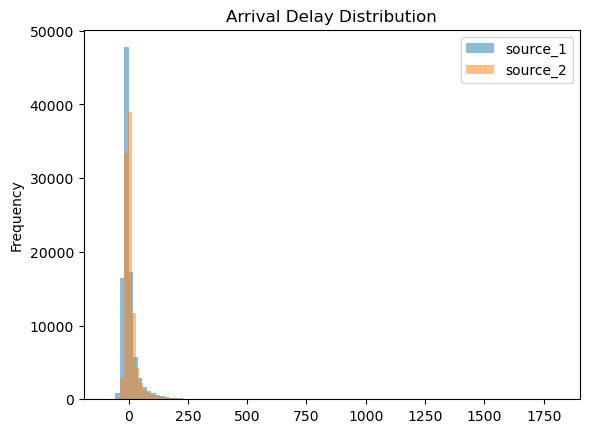

In [249]:
data_df.groupby('source')['ArrDelay'].plot(kind='hist', bins=100, alpha=0.5, legend=True, title='Arrival Delay Distribution')
plt.savefig('figures/ArrDelayDistribution.png')

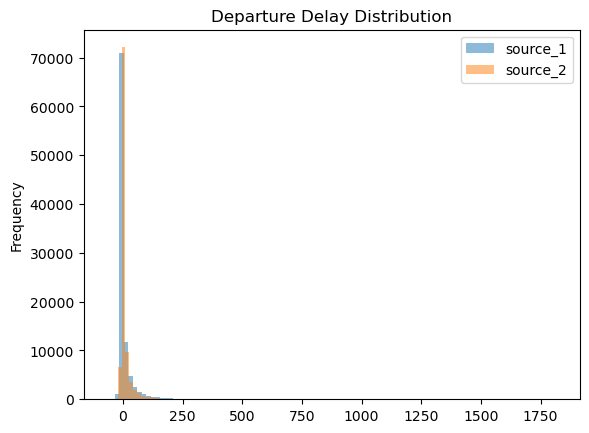

In [250]:
data_df.groupby('source')['DepDelay'].plot(kind='hist', bins=100, alpha=0.5, legend=True, title='Departure Delay Distribution')
plt.savefig('figures/DepDelayDistribution.png')

### Distribution of flights

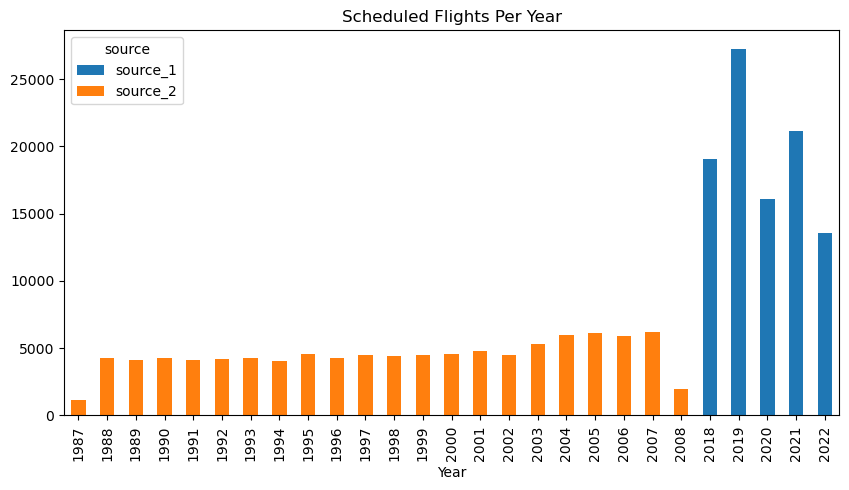

In [251]:
data_df.groupby('source')['Year'].value_counts().sort_index().unstack().unstack().unstack().plot(kind="bar", figsize=(10, 5), title="Scheduled Flights Per Year", stacked=True)
plt.savefig('figures/FlightCountPerYear.png')

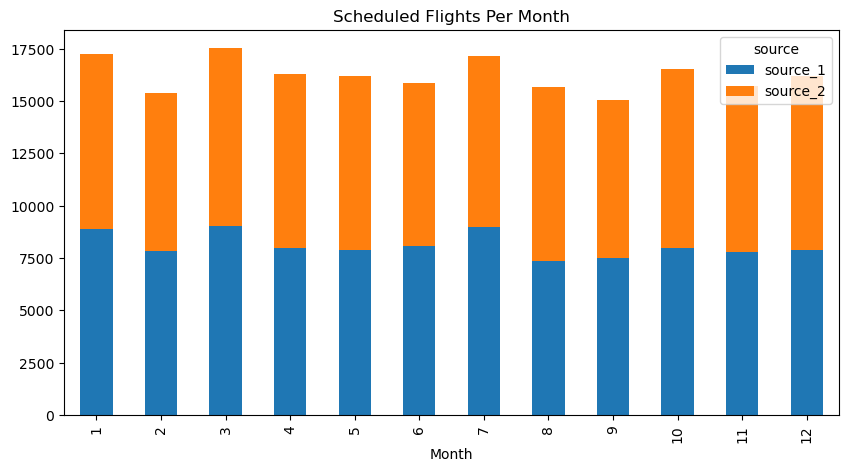

In [252]:
data_df.groupby('source')['Month'].value_counts().sort_index().unstack().unstack().unstack().plot(kind="bar", figsize=(10, 5), title="Scheduled Flights Per Month", legend=True, stacked=True)
plt.savefig('figures/FlightCountPerMonth.png')

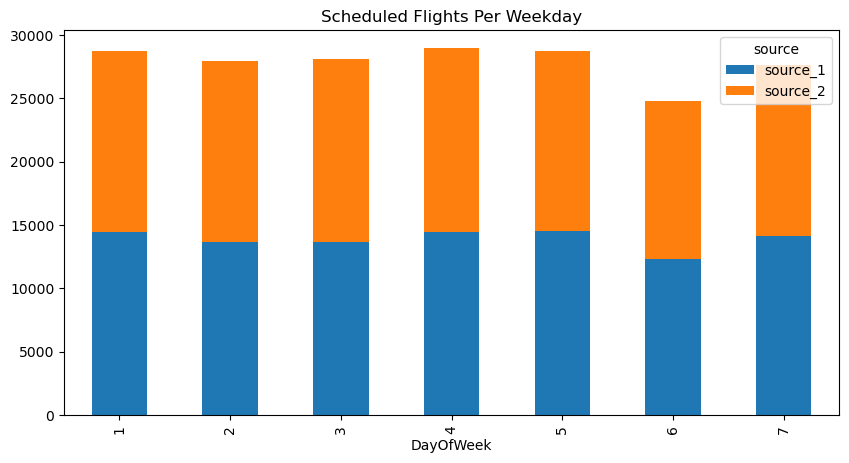

In [253]:
data_df.groupby('source')['DayOfWeek'].value_counts().sort_index().unstack().unstack().unstack().plot(kind="bar", figsize=(10, 5), title="Scheduled Flights Per Weekday", legend=True, stacked=True)
plt.savefig('figures/FlightCountPerWeekday.png')

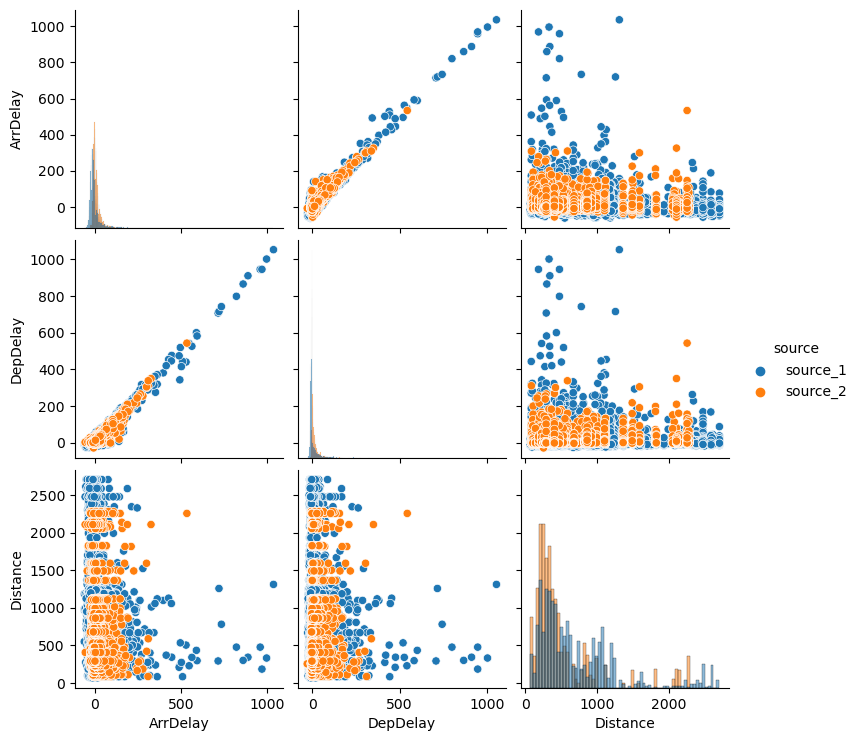

In [ ]:
# 2   Cancelled          2000 non-null   int64   
#  3   Diverted           2000 non-null   int64   
#  4   CRSDepTime         2000 non-null   int64   
#  5   DepTime            1928 non-null   float64 
#  6   DepDelay           1912 non-null   float64 
#  7   ArrTime            1927 non-null   float64 
#  8   AirTime            1345 non-null   float64 
#  9   CRSElapsedTime     2000 non-null   float64 
#  10  ActualElapsedTime  1927 non-null   float64 
#  11  Distance           2000 non-null   float64 
#  22  CRSArrTime         2000 non-null   int64   
#  23  ArrDelay           1906 non-null   float64
sns.pairplot(data_df[['ArrDelay', 'DepDelay', 'Distance', 'source']], hue='source', diag_kind='hist')

### Corona impact on delays

In the .
We aim to answer what i

Due to the travel restrictions implemented to reduce the spread of the corona virus

<Axes: title={'center': 'Scheduled Flights Per Month'}, xlabel='Year'>

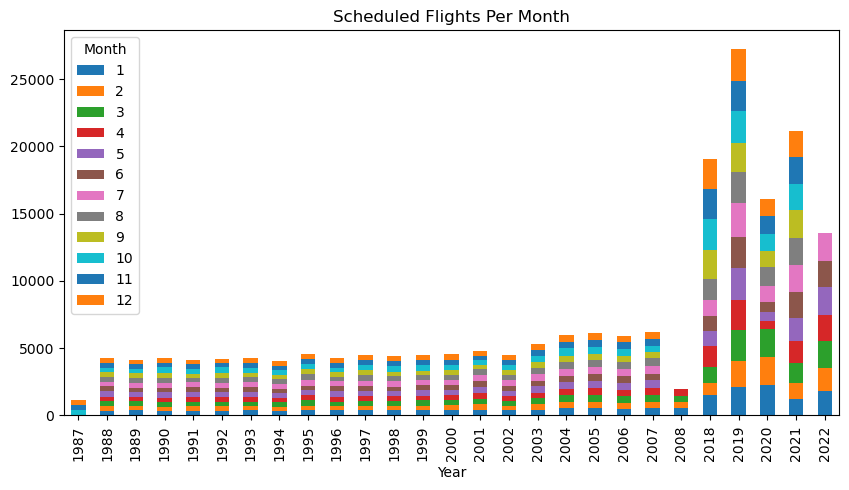

In [258]:
data_df.groupby(['Year', 'Month']).size().unstack().plot(kind='bar', figsize=(10, 5), title='Scheduled Flights Per Month', stacked=True)

<Axes: title={'center': 'Maximum Arrival Delay Per Month'}, xlabel='Year'>

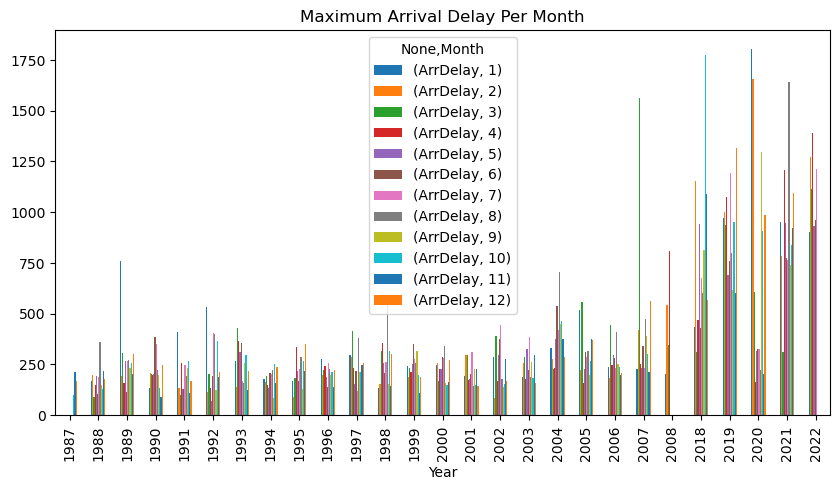

In [287]:
data_df.groupby(['Year', 'Month'])[['ArrDelay']].max().unstack().plot(kind='bar', figsize=(10, 5), title='Maximum Arrival Delay Per Month')

## Dealing with missing values

In [243]:
perc_empty: pd.Series = preprocessing.percentage_missing_values_per_column(data_df)
print(perc_empty[perc_empty > 0])

data_df.drop(['AirTime', 'TaxiIn', 'TaxiOut', 'Tail_Number'], axis=1, inplace=True)

AirTime              17.7460
TaxiIn               16.8570
TaxiOut              16.8320
Tail_Number          15.9905
ArrDelay              2.4880
ActualElapsedTime     2.4865
ArrTime               2.3900
DepDelay              2.2240
DepTime               2.2235
Distance              0.0815
OriginState           0.0185
OriginCityName        0.0185
DestCityName          0.0150
DestState             0.0150
CRSElapsedTime        0.0115
dtype: float64


Since the remaining columns contain very few samples with empty values, we drop these samples.

In [254]:
data_df.dropna(subset=['ArrDelay', 'DepDelay', 'Distance'], inplace=True)

In [245]:
data_df = data_df[data_df['Diverted'] == False]
data_df = data_df[data_df['Cancelled'] == False]
data_df.drop(['Diverted', 'Cancelled'], axis=1, inplace=True)

## Feature selection

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   CRSArrTime         20000 non-null  int64   
 1   Origin             20000 non-null  category
 2   CRSDepTime         20000 non-null  int64   
 3   Dest               20000 non-null  category
 4   DestState          20000 non-null  category
 5   DepTime            19537 non-null  float64 
 6   CRSElapsedTime     20000 non-null  float64 
 7   Diverted           20000 non-null  bool    
 8   DestCityName       20000 non-null  category
 9   OriginState        20000 non-null  category
 10  DayOfWeek          20000 non-null  category
 11  Cancelled          20000 non-null  bool    
 12  ArrTime            19495 non-null  float64 
 13  Airline            20000 non-null  category
 14  Month              20000 non-null  category
 15  ArrDelay           19416 non-null  float64 
 16  Actu

### Low variance filter

All the features have a high varianace

In [ ]:
data_df.var()

/var/folders/c9/24l9wbvn7_l_zt25742x5qf40000gn/T/ipykernel_33963/2238367851.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_df.var()


CRSArrTime           236525.924969
CRSDepTime           223326.313831
DepTime              232439.306223
CRSElapsedTime         4910.718013
ArrTime              247599.584328
ArrDelay               1689.056768
ActualElapsedTime      4760.000222
Distance             299366.568515
DepDelay               1468.835942
dtype: float64

### High correlation filter

/var/folders/c9/24l9wbvn7_l_zt25742x5qf40000gn/T/ipykernel_33963/2716785272.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_df.corr().abs())


<Axes: >

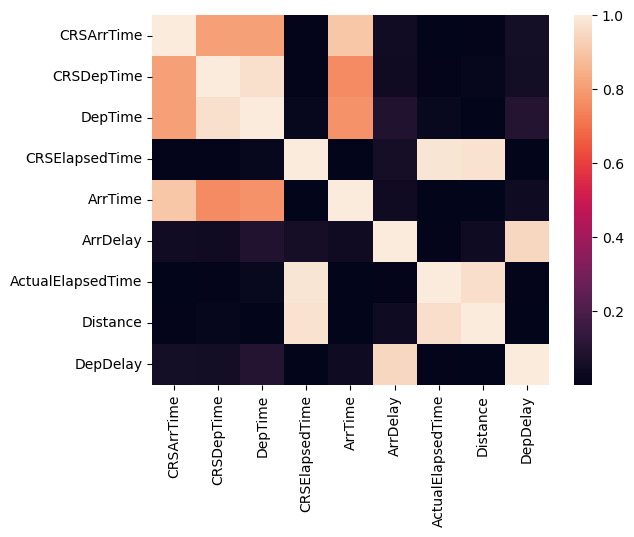

In [188]:
sns.heatmap(data_df.corr().abs())

## Seperate dependant and independant variables

In [ ]:
x, y = data_df[['CRSArrTime', 'CRSDepTime', 'CRSElapsedTime', 'Distance']], data_df[['DepDelay', 'ArrDelay']]

In [291]:
data_df['ArrDelay'].describe()

count    194862.000000
mean          5.479704
std          41.605672
min         -94.000000
25%         -12.000000
50%          -3.000000
75%           9.000000
max        1806.000000
Name: ArrDelay, dtype: float64